In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import expit
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

sns.set(style='ticks', font_scale=1.5)
blue, green, red, purple = sns.color_palette('deep', n_colors=4)

# More regression, classification, etc

Last week, we looked at how to fit and evaluate linear regression and logistic regression models using the `statsmodels` package. This week, we will explore the [scikit-learn](http://scikit-learn.org/stable/), or `sklearn` package. The two packages overlap a fair amount, at least with respect to regression and logistic regression models, and there are similarities and differences between the two packages' approach to these sorts of models.

First, we'll generate some random data with known $\beta$ coefficients so that we can evaluate how well the modeling algorithms do recovering the model parameters.

We can use `np.random.seed()` to reproduce (pseudo-)random numbers so that we can reproduce our results as needed. Setting the seed will cause the random number generator to produce the same sequence of pseudo-random numbers.

So, for example, if we set the seed equal to 6 and then generate five normal random variates, we get:

In [2]:
np.random.seed(seed=6)
np.random.normal(size=5)

array([-0.31178367,  0.72900392,  0.21782079, -0.8990918 , -2.48678065])

Then if we set the seed to 7, we get:

In [3]:
np.random.seed(seed=7)
np.random.normal(size=5)

array([ 1.6905257 , -0.46593737,  0.03282016,  0.40751628, -0.78892303])

If we go back and set it to 6 again, we get the same thing we got when we set it to 6 the first time:

In [4]:
np.random.seed(seed=6)
np.random.normal(size=5)

array([-0.31178367,  0.72900392,  0.21782079, -0.8990918 , -2.48678065])

We will create give random variables with different distributions, just to make things (moderately) interesting. We'll make one normal random variable, one laplace, one triangular, one Von Mises, and one logistic:

In [5]:
np.random.seed(seed=55555)
nsmp = 150 # number of "observations"

# generate random numbers and stick them together into an array
X = np.stack((stats.norm.rvs(size=nsmp, loc=0, scale=1),
              stats.laplace.rvs(size=nsmp, loc=0, scale=1),
              stats.triang.rvs(loc=-2.5, c=.5, scale=5, size=nsmp),
              stats.cosine.rvs(loc=0,scale=2,size=nsmp),
              stats.logistic.rvs(loc=0,scale=1,size=nsmp)),axis=1)

col_names = ['x1','x2','x3','x4','x5']

# make a data frame
df_X = pd.DataFrame(X,columns=col_names,index=np.arange(nsmp))
df_X.head()

,x1,x2,x3,x4,x5
0,0.315285,-0.003207,-1.437216,-4.508314,-1.146725
1,0.245975,-0.282873,-1.785265,0.951078,-2.183040
2,2.171328,1.304174,0.368489,-1.879425,1.929869
3,-1.454182,0.156729,-0.391970,4.242391,-0.164466
4,0.101272,0.132085,1.531524,-2.641646,2.310899


Here is what the theoretical probability density functions look like for the random variables we generated:

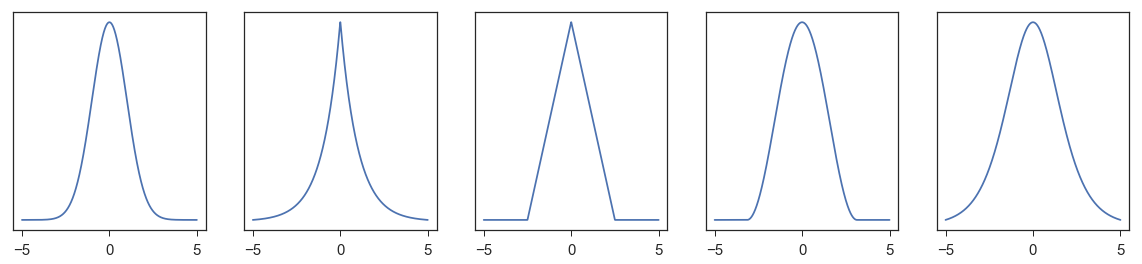

In [6]:
fig, axes = plt.subplots(1,5,figsize=(20,4))
xax = np.linspace(-5,5,1000)
axes[0].plot(xax,stats.norm.pdf(xax, loc=0, scale=1))
axes[1].plot(xax,stats.laplace.pdf(xax, loc=0, scale=1))
axes[2].plot(xax,stats.triang.pdf(xax, loc=-2.5, c=.5, scale=5))
axes[3].plot(xax,stats.cosine.pdf(xax, loc=0, scale=1))
axes[4].plot(xax,stats.logistic.pdf(xax, loc=0, scale=1))
[axes[i].set(yticks=[]) for i in range(5)];

We can create a matrix of scatter plots to see what the data looks like (and how much they diverge from the theoretical pdfs above). Because we created each random variable independently of each other, the variables are not highly correlated.

`np.corrcoef(array)` gives you a correlation matrix for the variables in the input array.

In [7]:
# corrcoef assumes variables are in rows, so we use X.T
print(np.corrcoef(X.T).round(2))

[[ 1.    0.26 -0.16  0.21 -0.03]
 [ 0.26  1.   -0.01 -0.01 -0.13]
 [-0.16 -0.01  1.   -0.08  0.2 ]
 [ 0.21 -0.01 -0.08  1.    0.07]
 [-0.03 -0.13  0.2   0.07  1.  ]]


We can visualize the data with a matrix of scatter plots:

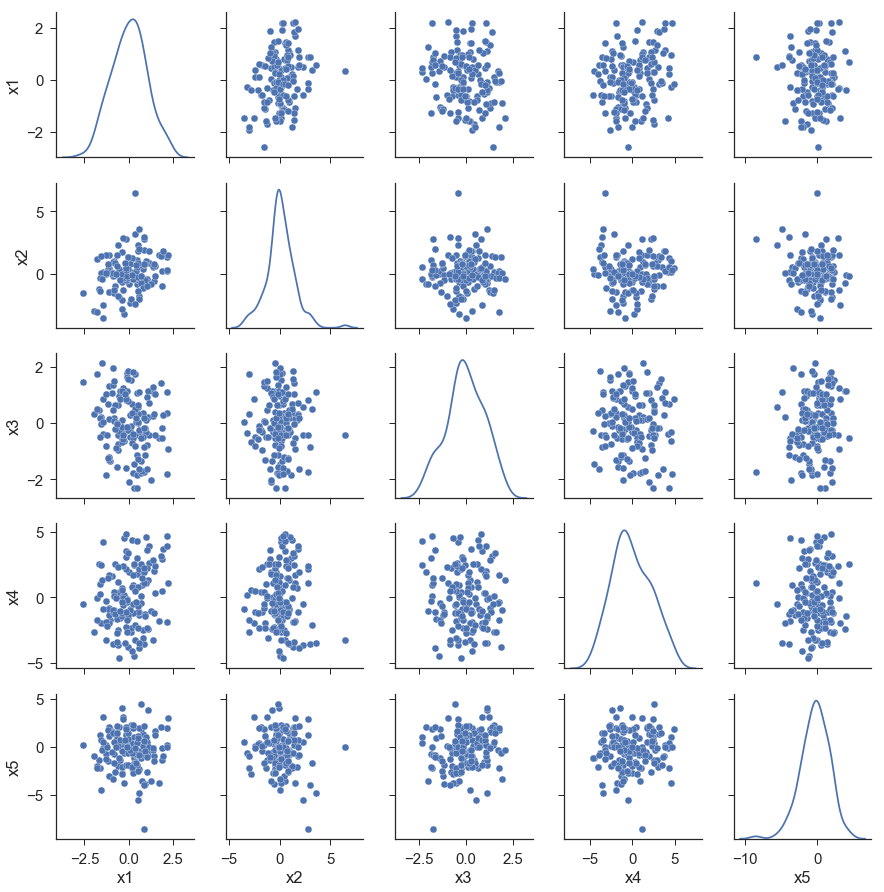

In [8]:
sns.pairplot(df_X,diag_kind='kde');

Next, we will create an array of $\beta$ coefficients, an error standard deviation $\sigma$, and use these with our `X` data frame to generate a dependent variable `y`:

In [9]:
B = np.array([17.5, -9.3, 2.4, -8.8, 11.2])
sigma = 3.2
mu_y = X @ B
y = np.random.normal(loc=mu_y, scale=sigma, size=nsmp)

Then we can visualize how `y` relates to each of our random `x` variables. Note that the linear model illustrated in each panel is for a model with just that variable used as a predictor (i.e., it's not the full model we'll fit below):

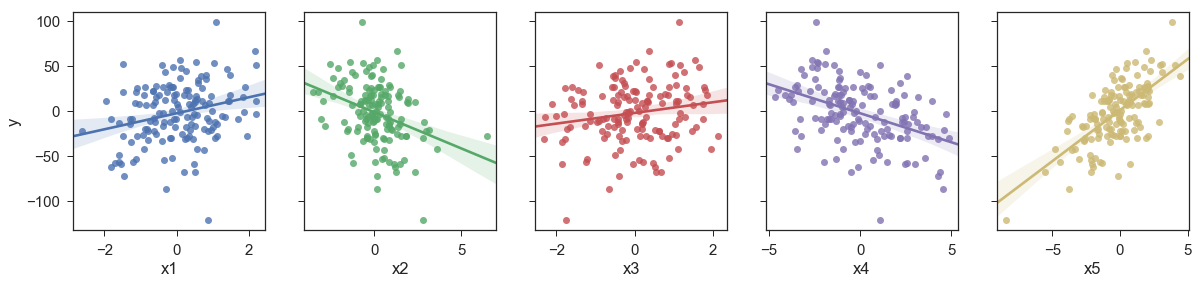

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].set_ylabel('y')

for i in range(5):
    sns.regplot(x=X[:,i],y=y,ax=axes[i], n_boot=100)
    axes[i].set_xlabel(col_names[i])
    if i > 0:
        axes[i].set_yticklabels([])

Next, we use the linear models that we imported from `sklearn`. More specifically, we'll fit linear regression and logistic regression models first, and we'll come back to ridge regression and the lasso model in a bit.

First, we'll fit a standard linear regression model, and check to see how the fitted parameter ($\beta$) estimates compare to the $\beta$ values we used to generate the data.

As with `statsmodels`, we create a model object (with some input arguments, as appropriate), and then we use the `fit()` method with data as input arguments:

In [11]:
lin_mod = LinearRegression(fit_intercept=False)
lin_fit = lin_mod.fit(X,y)

Here are the estimated parameters ($\beta$ coefficients):

In [12]:
np.round(lin_fit.coef_,1)

array([ 17.7,  -9.3,   2.7,  -8.7,  11. ])

And here are the values we used to generate the data above:

In [13]:
B

array([ 17.5,  -9.3,   2.4,  -8.8,  11.2])

So, in this case, at least, the model did a good job recovering the known parameter values.

We can generate random data with the same parameters repeatedly to measure how much variation there is in fitted model parameters across different random samples:

In [14]:
nsim = 250 # number of simulations
nprd = len(B) # number of predictors
pars = np.zeros((nsim,nprd)) # container for fitted coefficients

for i in range(nsim):
    # generate a new random X matrix for simulation i
    Xt = np.stack((stats.norm.rvs(size=nsmp, loc=0, scale=1),
                   stats.laplace.rvs(size=nsmp, loc=0, scale=1),
                   stats.triang.rvs(loc=-2.5, c=.5, scale=5, size=nsmp),
                   stats.cosine.rvs(loc=0,scale=2,size=nsmp),
                   stats.logistic.rvs(loc=0,scale=1,size=nsmp)),axis=1)
    # generate a new random y vector for simulation i
    yt = np.random.normal(loc=Xt @ B, scale=sigma, size=nsmp)
    # fit a linear model with simulated Xt and yt
    lf_t = lin_mod.fit(Xt,yt)
    # store the fitted parameters/coefficients from the model
    pars[i,:] = lf_t.coef_

We can use seaborn's `distplot()` to visualize the distributions of $\beta$ estimates:

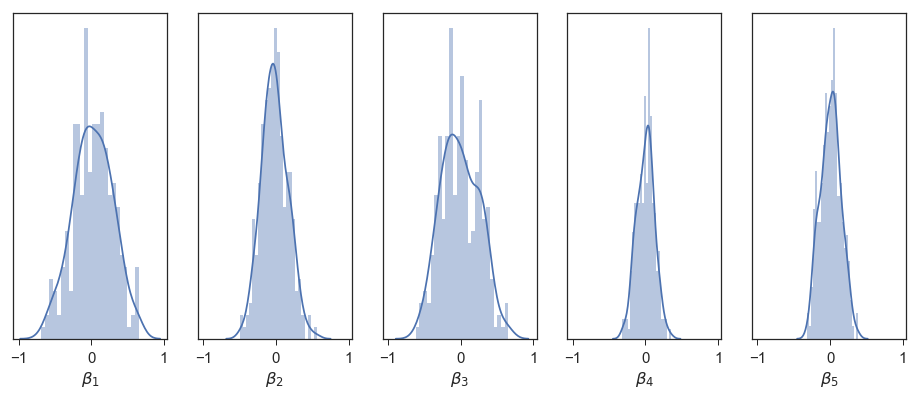

In [16]:
fig, axes = plt.subplots(1,nprd,figsize=(16,6), sharex=True)
[sns.distplot(pars[:,i]-B[i],ax=axes[i],bins=25) for i in range(nprd)]
indices = [r'$\beta_' + str(i) + '$' for i in range(1,nprd+1)]
[axes[i].set(xlabel=indices[i],yticks=[]) for i in range(nprd)];

Next, in order to illustrate fitting a logistic regression model, we'll make a dichotomous outcome variable, fit a logistic regression model, and check how the fitted parameters compare to the true parameters:

In [19]:
# expit function for turning X @ B into probabilities
#  expit(x) = 1/(1+np.exp(-x))
Bsc = B/10 # scale the coefficients
p = expit(X @ Bsc) # generate predicted probabilities
b = (p > .57)*1 # dichotomize p
p[:10]

array([ 0.94748856,  0.04666864,  0.99848485,  0.00122676,  0.9952023 ,
        0.96561392,  0.33271521,  0.32158936,  0.79754037,  0.26000141])

In [20]:
b[:10]

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

In [21]:
log_mod = LogisticRegression(fit_intercept=False) # logistic regression model
log_fit = log_mod.fit(X,b) # fit the model

In [22]:
log_fit.coef_[0].round(2)

array([ 2.56, -1.49,  0.54, -1.45,  2.22])

In [23]:
Bsc

array([ 1.75, -0.93,  0.24, -0.88,  1.12])

Using a sequence of `regplot`s, we can see what the data looks like (with fitted **univariate** logistic model predictions):

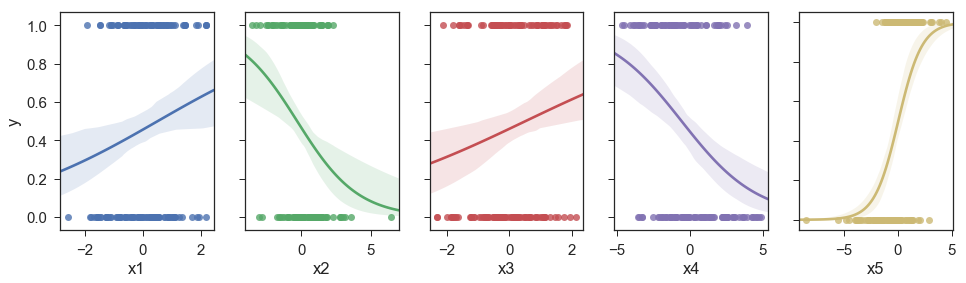

In [24]:
fig, axes = plt.subplots(1,5,figsize=(16,4))
axes[0].set_ylabel('y')
[sns.regplot(x=X[:,i],y=b,ax=axes[i], logistic=True, n_boot=100) for i in range(5)]
[axes[i].set_yticklabels([]) for i in range(1,5)]
[axes[i].set_xlabel(col_names[i]) for i in range(5)];

As with the linear regression model above, we can simulate data and quantify how variable and how consistently biased the logistic regression estimates are:

In [25]:
nsim = 250
nprd = len(B)
pars = np.zeros((nsim,nprd))

for i in range(nsim):
    Xt = np.stack((stats.norm.rvs(size=nsmp, loc=0, scale=1),
                   stats.laplace.rvs(size=nsmp, loc=0, scale=1),
                   stats.triang.rvs(loc=-2.5, c=.5, scale=5, size=nsmp),
                   stats.cosine.rvs(loc=0,scale=2,size=nsmp),
                   stats.logistic.rvs(loc=0,scale=1,size=nsmp)),axis=1)
    pt = expit(Xt @ Bsc)
    bt = (p > .57)*1
    lf_t = log_mod.fit(Xt,bt)
    pars[i,:] = lf_t.coef_[0]

And we can visualize them as we did above (more or less):

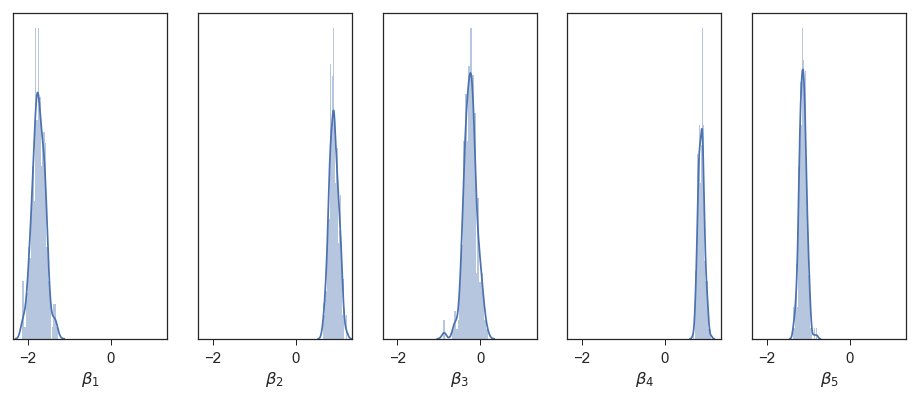

In [26]:
fig, axes = plt.subplots(1,nprd,figsize=(16,6), sharex=True)
xax_lims = (1.1*np.min(pars-Bsc),1.1*np.max(pars-Bsc))
[sns.distplot(pars[:,i]-Bsc[i],ax=axes[i],bins=25) for i in range(nprd)]
indices = [r'$\beta_' + str(i) + '$' for i in range(1,nprd+1)]
[axes[i].set(xlabel=indices[i],yticks=[],xlim=xax_lims) for i in range(nprd)];

Standard linear regression seems to do a good job recovering the true parameter values, but logistic regression doesn't. It gets the sign right, and it's very precise, but it's inaccurate. In statistical terminology, it exhibits fairly substantial bias.

Note that this doesn't imply that logistic regression is a bad tool. The way we generated our dichotomous dependent variable was unusual, plausibly not accurately reflecting any mechanisms we might encounter in the world, for example.

As discussed above, the random variables we've been dealing with so far are not particularly highly correlated. Let's see what happens when we have correlated independent variables. To do this, we'll generate multivariate normal data with some substantial correlations:

In [28]:
np.random.seed(seed=55562) # set rng seed
nsmp = 150 # number of "observations"
mu = np.zeros(5) # mean vector
S = np.linalg.inv(stats.wishart.rvs(scale=np.eye(5)/10,df=6,size=1)) # covariance matrix
X = np.random.multivariate_normal(mean=mu, cov=S, size=nsmp)
df_X = pd.DataFrame(X,columns=col_names,index=np.arange(nsmp))
np.corrcoef(X.T).round(2)

array([[ 1.  ,  0.71, -0.24,  0.47,  0.71],
       [ 0.71,  1.  ,  0.14,  0.89,  0.86],
       [-0.24,  0.14,  1.  ,  0.43, -0.14],
       [ 0.47,  0.89,  0.43,  1.  ,  0.68],
       [ 0.71,  0.86, -0.14,  0.68,  1.  ]])

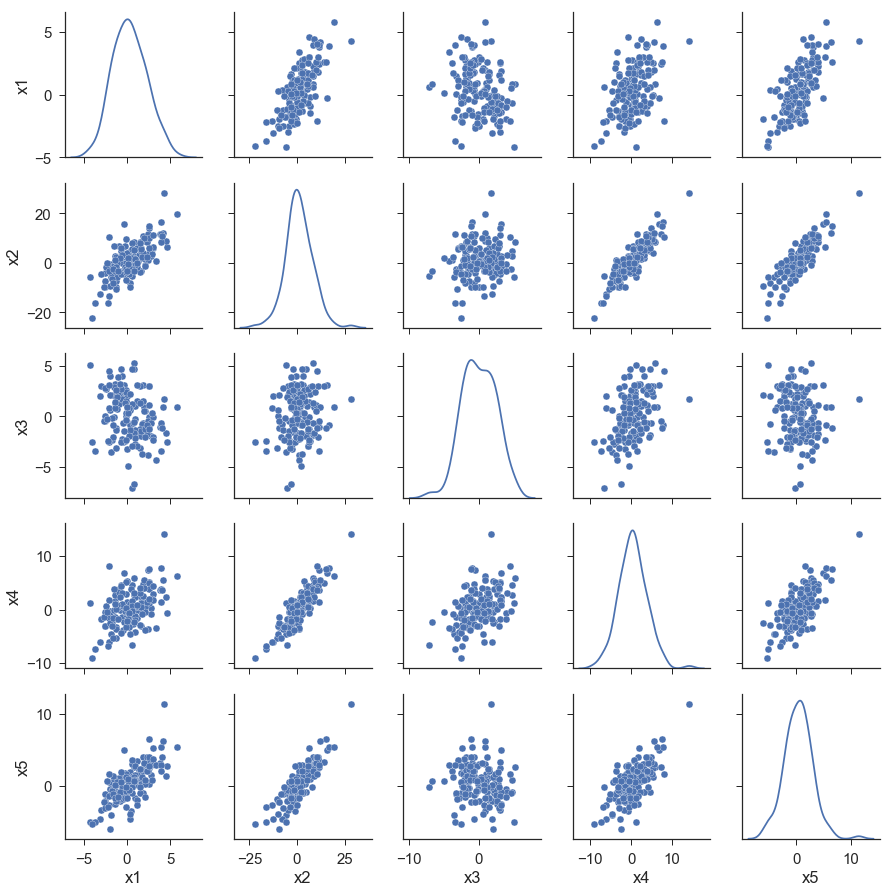

In [29]:
sns.pairplot(df_X,diag_kind='kde');

We'll use the same $\beta$ and $\sigma$ parameters that we used above:

In [30]:
B

array([ 17.5,  -9.3,   2.4,  -8.8,  11.2])

In [31]:
sigma

3.2

In [32]:
y = np.random.normal(loc=X @ B, scale=sigma, size=nsmp)

We can visualize the relationships between y and each independent variable (again, keeping in mind that the regression line in each panel is fit just to the two variables in the panel, **not** the full set of predictors):

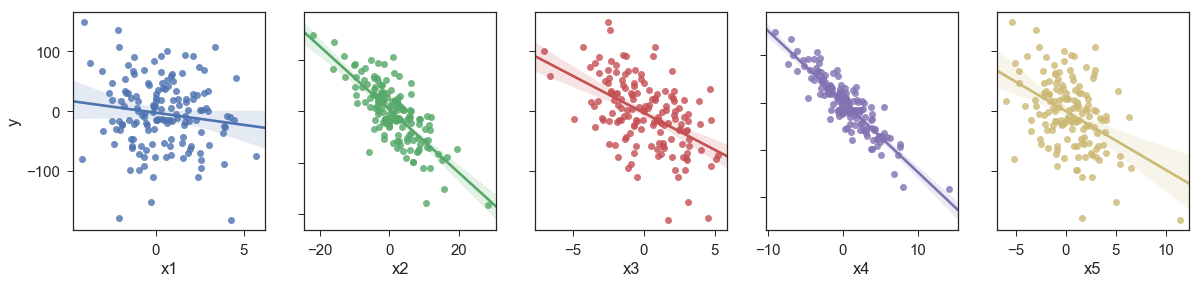

In [33]:
fig, axes = plt.subplots(1,5,figsize=(20,4))
axes[0].set_ylabel('y')
[sns.regplot(x=X[:,i],y=y,ax=axes[i], n_boot=100) for i in range(5)]
[axes[i].set_yticklabels([]) for i in range(1,5)]
[axes[i].set_xlabel(col_names[i]) for i in range(5)];

As above, the standard linear model does a good job of recovering the true parameter values:

In [35]:
lin_mod = LinearRegression(fit_intercept=False)
lin_fit = lin_mod.fit(X,y)

In [36]:
lin_fit.coef_.round(2)

array([ 17.9 ,  -9.31,   2.46,  -8.84,  11.15])

In [37]:
B

array([ 17.5,  -9.3,   2.4,  -8.8,  11.2])

We won't bother simulating multiple data sets to check the variability of the estimates this time.

### Lasso and Ridge Regression and regularization

As briefly discussed last week, [lasso regression](http://scikit-learn.org/stable/modules/linear_model.html#lasso) is a tool for regularization - roughly, putting pressure on a model to constrain its complexity. This can help with making more reliable predictions, though it makes it difficult (if not impossible) to interpret the parameter estimates we get from a fitted model.

In `sklearn` as in `statsmodels`, fitting a lasso model is just like fitting a regular linear regression model, but we also need to specify an $\alpha$ parameter. Larger $\alpha$ values put more pressure on the model to keep the size of the coefficients small.

In [38]:
lasso_mod = Lasso(alpha=10, fit_intercept=False)
lasso_fit = lasso_mod.fit(X,y)

In [39]:
np.round(lasso_fit.coef_,1)

array([ 11. ,  -4.6,  -0. ,  -9.9,   2.8])

In [40]:
B

array([ 17.5,  -9.3,   2.4,  -8.8,  11.2])

We can illustrate how the parameter estimates change as $\alpha$ increases:

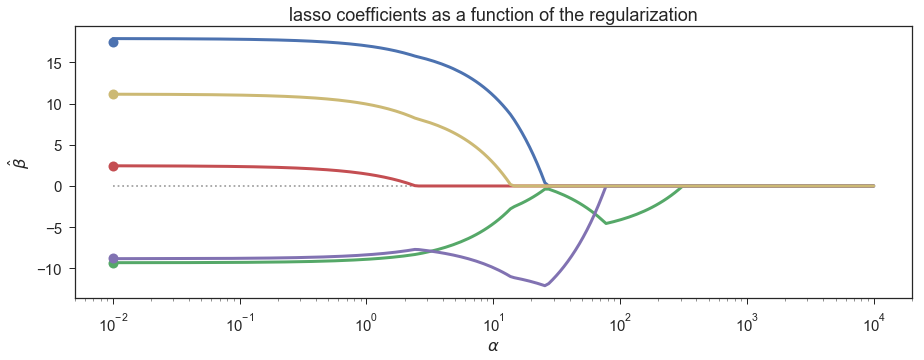

In [41]:
n_alphas = 200 # number of alpha values to visualize the effect of
alphas = np.logspace(-2, 4, n_alphas)

coefs = [] # container for storing coefficients
for a in alphas:
    lasso_mod.set_params(alpha=a) # set the alpha parameter
    lasso_mod.fit(X, y) # fit the model
    coefs.append(lasso_mod.coef_) # append the coefficients to container list
    
fig, ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(alphas,np.zeros(n_alphas),':',c=[.5,.5,.5,.75])

ll = ax.plot(alphas, coefs, lw=3)
[ax.plot(alphas[0],B[i],'o',ms=10,c=ll[i].get_c()) for i in range(len(B))]
ax.set_xscale('log'); ax.set_xlabel(r'$\alpha$'); ax.set_ylabel(r'$\hat{\beta}$');
plt.title('lasso coefficients as a function of the regularization');

[Ridge regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) is another regularization method. It is implemented similarly:

In [42]:
ridge_mod = Ridge(alpha=10**4,fit_intercept=False, normalize=False)
ridge_fit = ridge_mod.fit(df_X,y)

In [43]:
np.round(ridge_fit.coef_,1)

array([ 0.2, -2.3, -0.8, -1.6, -0.3])

In [44]:
B

array([ 17.5,  -9.3,   2.4,  -8.8,  11.2])

As above, we can visualize strength of regularization with ridge regression:

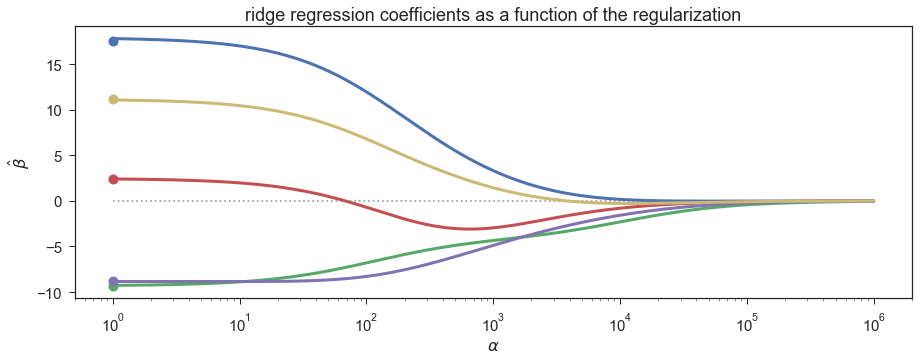

In [45]:
alphas = np.logspace(0, 6, n_alphas)

coefs = []
for a in alphas:
    ridge_mod.set_params(alpha=a)
    ridge_mod.fit(X, y)
    coefs.append(ridge_mod.coef_)
    
fig, ax = plt.subplots(1,1,figsize=(15,5))

ax.plot(alphas,np.zeros(n_alphas),':',c=[.5,.5,.5,.75])
ll = ax.plot(alphas, coefs, lw=3)
[ax.plot(alphas[0],B[i],'o',ms=10,c=ll[i].get_c()) for i in range(len(B))]
ax.set_xscale('log')
ax.set_xlabel(r'$\alpha$'); ax.set_ylabel(r'$\hat{\beta}$');
plt.title('ridge regression coefficients as a function of the regularization');

### Quantifying testing error as a function of alpha in regularized regression

We can see how prediction error varies with alpha (i.e., the magnitude of regularization) to illustrate its utility.

First, we'll we'll define a function for quantifying the discrepency between predictions and data. Then, we'll split the data in `X` into $k=10$ "folds" (i.e., 10 sets) of training and testing data. That is, we'll use `KFold()` to generate random indices so that we can fit the data to 90% of the data and test it on the 10% we withhold for each fold, measuring the error between the predicted values (based on the training data) and the withheld data.

In [46]:
def pred_err(pred, obs, L_norm=2):
    if L_norm==1:
        return np.mean(np.abs(pred-obs)) # mean absolute error
    elif L_norm==2:
        return np.sqrt(np.mean((pred-obs)**2)) # root mean squared error

Here is an illustration of how the `KFold` object works:

In [51]:
kf = KFold(n_splits=3, shuffle=True, random_state=98765)

for idx in kf.split(X):
    print('training set indices: ',idx[0])
    print(' ')
    print('test set indices: ',idx[1])
    print(' ')

training set indices:  [  0   1   2   3   4   5   6   9  10  11  13  14  15  17  18  19  20  21
  24  26  27  28  31  34  36  38  42  43  44  45  46  48  49  50  52  53
  54  56  58  59  62  63  65  66  69  70  71  73  74  75  76  77  79  80
  81  82  83  85  89  90  93  94  96  97 101 102 103 104 105 106 107 108
 109 110 111 112 113 115 117 118 119 123 124 126 127 128 129 132 133 136
 137 138 139 140 142 144 145 146 147 149]
 
test set indices:  [  7   8  12  16  22  23  25  29  30  32  33  35  37  39  40  41  47  51
  55  57  60  61  64  67  68  72  78  84  86  87  88  91  92  95  98  99
 100 114 116 120 121 122 125 130 131 134 135 141 143 148]
 
training set indices:  [  2   6   7   8   9  11  12  14  16  17  18  21  22  23  25  26  28  29
  30  31  32  33  35  36  37  38  39  40  41  45  46  47  48  51  53  54
  55  57  58  59  60  61  62  64  67  68  71  72  73  74  76  78  79  84
  85  86  87  88  90  91  92  93  95  96  98  99 100 102 103 104 105 106
 108 110 111 114 115 116 117

Finally, we'll fit lasso and ridge regression models with a range of alpha values, calculate prediction error, and plot the results:

In [52]:
n_alphas = 50
n_splits = 10
lasso_alphas = np.logspace(-2, 4, n_alphas) 
ridge_alphas = np.logspace(0, 6, n_alphas)
lasso_pred_err = np.zeros((2,n_splits,n_alphas)) # container for lasso prediction error
ridge_pred_err = np.zeros((2,n_splits,n_alphas)) # container for ridge prediction error

# set up the k-fold splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=98765)

for ai, av in enumerate(zip(lasso_alphas, ridge_alphas)):
    lav, rav = av # extract lasso and ridge alphas from av tuple
    lasso_mod.set_params(alpha=lav)
    ridge_mod.set_params(alpha=rav)
    
    for ti, indices in enumerate(kf.split(X)):
        train_idx, test_idx = indices # extract training and test set indices
        X_train = X[train_idx,:]
        y_train = y[train_idx]
        X_test = X[test_idx,:]
        y_test = y[test_idx]

        lasso_mod.fit(X_train,y_train) # "train" the lasso model on X_train, y_train
        l_pred_t = lasso_mod.predict(X_test) # predict values of y based on X_test
        lasso_pred_err[0,ti,ai] = pred_err(l_pred_t, y_test, L_norm=1)
        lasso_pred_err[1,ti,ai] = pred_err(l_pred_t, y_test, L_norm=2)
    
        ridge_mod.fit(X_train,y_train) # train the ridge regression model
        r_pred_t = ridge_mod.predict(X_test) # predict for withheld data
        ridge_pred_err[0,ti,ai] = pred_err(r_pred_t, y_test, L_norm=1)
        ridge_pred_err[1,ti,ai] = pred_err(r_pred_t, y_test, L_norm=2)

lasso_error = lasso_pred_err.sum(axis=1)
ridge_error = ridge_pred_err.sum(axis=1)

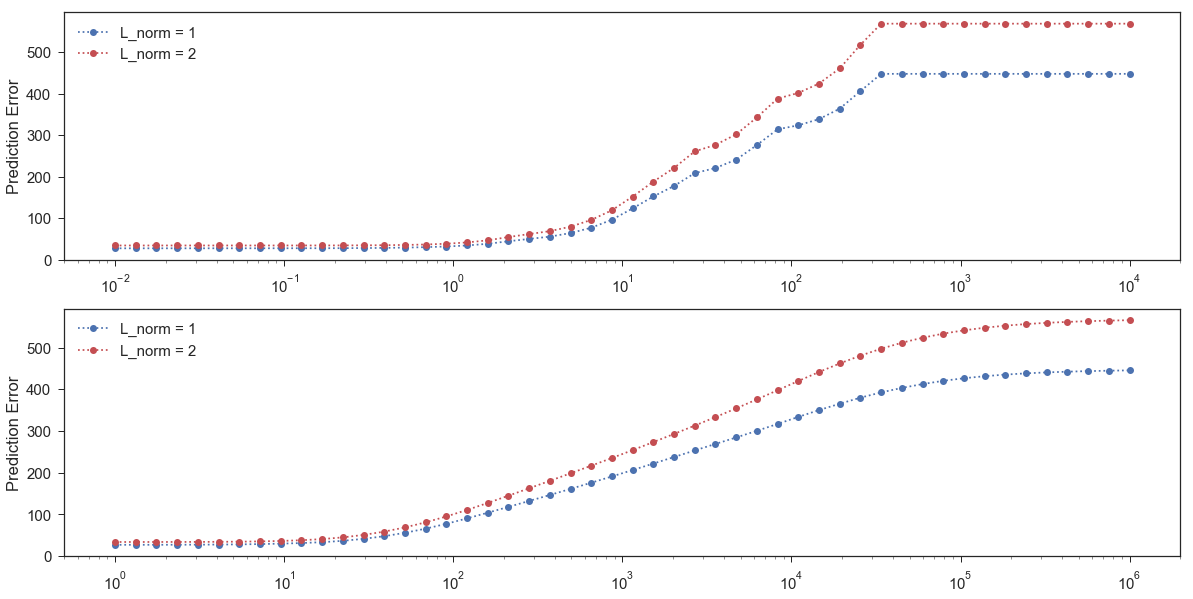

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(20,10))
axl, axr = axes
l_1, = axl.plot(lasso_alphas, lasso_error[0,:], 'o:', color=blue)
l_2, = axl.plot(lasso_alphas, lasso_error[1,:], 'o:', color=red)
axl.legend([l_1,l_2],['L_norm = 1','L_norm = 2'])
axl.set_xscale('log'); axl.set(ylabel='Prediction Error')
l_1, = axr.plot(ridge_alphas, ridge_error[0,:], 'o:', color=blue)
l_2, = axr.plot(ridge_alphas, ridge_error[1,:], 'o:', color=red)
axr.legend([l_1,l_2],['L_norm = 1','L_norm = 2'])
axr.set_xscale('log'); axr.set(ylabel='Prediction Error');

For both of these models, weak (or no) regularization clearly does just fine. This was a bit surprising to me, but maybe I was overly convinced of how useful lasso and ridge regression are. We'll see how these tools do with real data below.

## Beyond regression and its generalizations

Among the many useful and interesting tools in scikit-learn are dimensionality reduction tools. For example, there are easy-to-use libraries for Principal Components Analysis ([PCA](http://scikit-learn.org/stable/modules/decomposition.html#pca)) and Linear Discriminant Analysis ([LDA](http://scikit-learn.org/stable/modules/lda_qda.html)).

We'll illustrate these with subsets of the multivariate normal data we generated above. Here are three pairs of those variables, with decreasing degrees of correlation (from left to right):

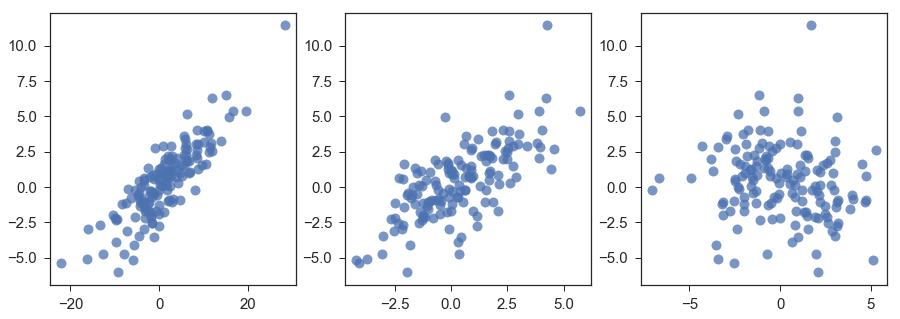

In [56]:
# pick out pairs of variables from X
X1 = X[:,[1,4]] # highly correlated
X2 = X[:,[0,4]] # moderately correlated
X3 = X[:,[2,4]] # weakly correlated
XX = [X1,X2,X3]

fig, axes = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    axes[i].plot(XX[i][:,0],XX[i][:,1],'o',ms=10,alpha=0.75)

We can use PCA to find the linear combinations of a set of variables that account for the most variance in the original set of variables. The first principal component will account for as much variance as possible, and the second principal component will account for as much variance as possible under the constraint that it must be orthogonal to the first principal component.

Each subsequent component must be orthogonal to all prior components. Ultimately, there are as many principal components as there are original variables. In some cases, we might want to select the first $N$ components to reduce the dimensionality of our data.

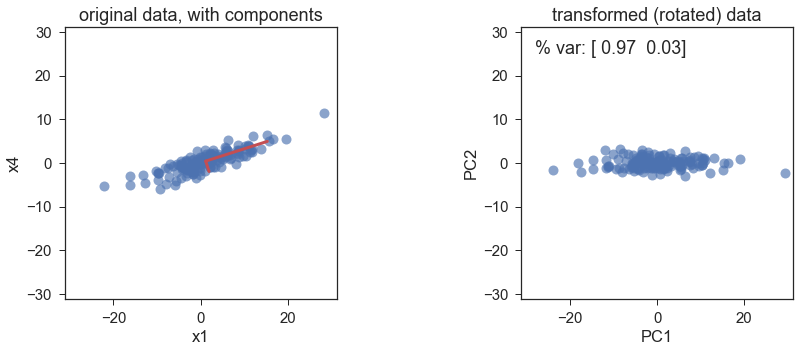

In [59]:
# create pca object, specify number of components
pca = PCA(n_components=2)
# get principal components for first pair of variables
P1 = pca.fit(X1)
# transform data to the principal componens
T1 = pca.fit_transform(X1)
# extract components
C1 = P1.components_
#C1[1,:] = -C1[1,:]
# put original data and transformed data into a list for plotting
XT = [X1,T1]
# get means of original data
M1 = P1.mean_
# get variance of principal components
V1 = P1.explained_variance_
# get proportion of variance accounted for by principal components
W1 = np.round(P1.explained_variance_ratio_,2)
# make plots
fig, axes = plt.subplots(1,2,figsize=(15,5))
[axes[i].plot(XT[i][:,0],XT[i][:,1],'o',ms=10,alpha=0.65) for i in range(2)];
ax_lim = 1.1*np.max(np.abs(X1))
[axes[i].set(xlim=(-ax_lim,ax_lim),ylim=(-ax_lim,ax_lim)) for i in range(2)]
[axes[i].set_aspect('equal') for i in range(2)]
axes[0].plot([M1[0],M1[0]+C1[0,0]*2*np.sqrt(V1[0])],[M1[1],M1[1]+C1[0,1]*2*np.sqrt(V1[0])],'-',color=red,lw=3)
axes[0].plot([M1[0],M1[0]+C1[1,0]*2*np.sqrt(V1[1])],[M1[1],M1[1]+C1[1,1]*2*np.sqrt(V1[1])],'-',color=red,lw=3)
axes[0].set_title('original data, with components')
axes[1].text(-.9*ax_lim,.8*ax_lim,'% var: ' + str(W1), fontsize=18)
axes[0].set(xlabel='x1', ylabel='x4')
axes[1].set(xlabel='PC1', ylabel='PC2')
axes[1].set_title('transformed (rotated) data');

In this case, the first principal component accounts for 97% of the variance that can be accounted for. This pair of variables is a good candidate for dimensionality reduction. We can describe most of the variation in the data with just the first component:

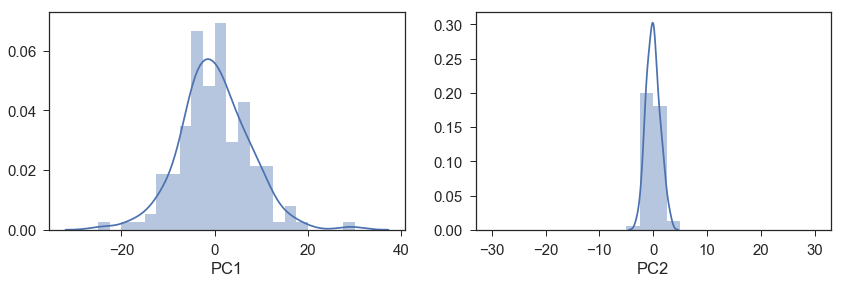

In [60]:
fig, axes = plt.subplots(1,2,figsize=(14,4)); bins = np.linspace(-30,30,25)
[sns.distplot(T1[:,i],bins=bins, ax=axes[i]) for i in range(2)]
[axes[i].set_xlabel('PC'+str(i+1)) for i in range(2)];

The second pair is slightly less strongly correlated, and the relative size of the two principal components reflects this:

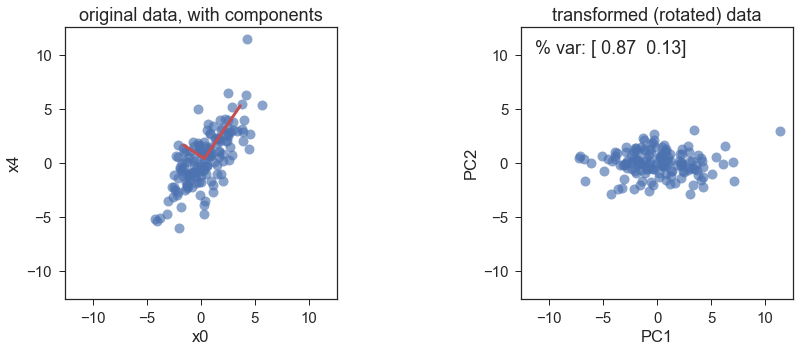

In [62]:
P2 = pca.fit(X2) # fit PCA
T2 = pca.fit_transform(X2) # transform data
XT = [X2,T2] # concatenate
C2 = P2.components_ # PCs
M2 = P2.mean_ # original mean values
V2 = P2.explained_variance_ # % variance accounted for
W2 = np.round(P2.explained_variance_ratio_,2) # rounded

fig, axes = plt.subplots(1,2,figsize=(15,5))
[axes[i].plot(XT[i][:,0],XT[i][:,1],'o',ms=10,alpha=0.65) for i in range(2)];
ax_lim = 1.1*np.max(np.abs(X2))
[axes[i].set(xlim=(-ax_lim,ax_lim),ylim=(-ax_lim,ax_lim)) for i in range(2)]
[axes[i].set_aspect('equal') for i in range(2)]
axes[0].plot([M2[0],M2[0]+C2[0,0]*2*np.sqrt(V2[0])],[M2[1],M2[0]+C2[0,1]*2*np.sqrt(V2[0])],'-',color=red,lw=3)
axes[0].plot([M2[0],M2[0]+C2[1,0]*2*np.sqrt(V2[1])],[M2[1],M2[0]+C2[1,1]*2*np.sqrt(V2[1])],'-',color=red,lw=3);
axes[0].set_title('original data, with components')
axes[1].text(-.9*ax_lim,.8*ax_lim,'% var: ' + str(W2), fontsize=18)
axes[0].set(xlabel='x0', ylabel='x4')
axes[1].set(xlabel='PC1', ylabel='PC2')
axes[1].set_title('transformed (rotated) data');

Again, we can visualize the distributions of the transformed data to illustrate the variation on the two principal components:

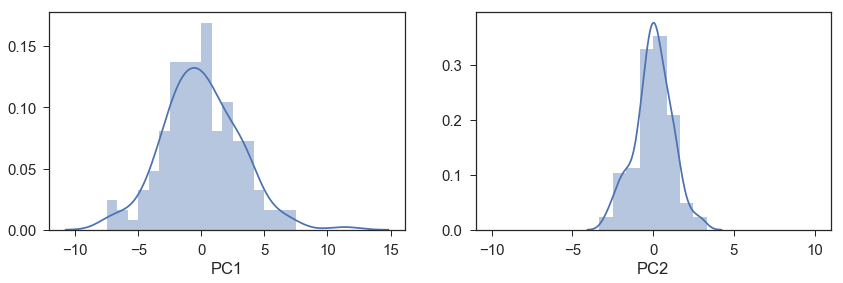

In [63]:
fig, axes = plt.subplots(1,2,figsize=(14,4)); bins = np.linspace(-10,10,25)
[sns.distplot(T2[:,i],bins=bins, ax=axes[i]) for i in range(2)]
[axes[i].set_xlabel('PC'+str(i+1)) for i in range(2)];

Finally, we can see what happens with two nearly uncorrelated variables:

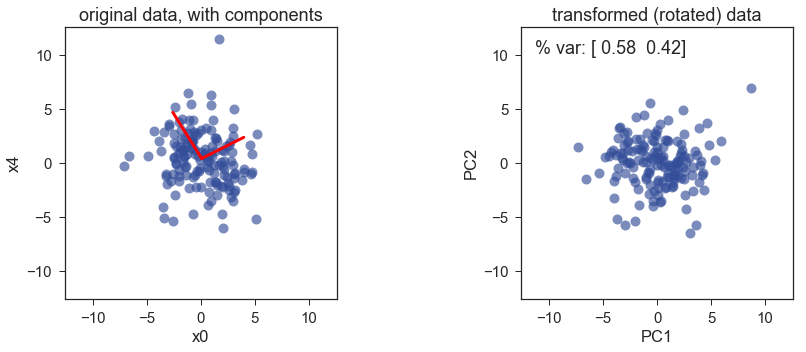

In [65]:
P3 = pca.fit(X3); T3 = pca.fit_transform(X3); XT = [X3,T3]
C3 = P3.components_; M3 = P3.mean_; V3 = P3.explained_variance_; W3 = np.round(P3.explained_variance_ratio_,2)

fig, axes = plt.subplots(1,2,figsize=(15,5))
[axes[i].plot(XT[i][:,0],XT[i][:,1],'o',ms=10,c=[.2,.3,.6,.65]) for i in range(2)];
ax_lim = 1.1*np.max(np.abs(X3))
[axes[i].set(xlim=(-ax_lim,ax_lim),ylim=(-ax_lim,ax_lim)) for i in range(2)]
[axes[i].set_aspect('equal') for i in range(2)]
axes[0].plot([M3[0],M3[0]+C3[0,0]*2*np.sqrt(V3[0])],[M3[1],M3[0]+C3[0,1]*2*np.sqrt(V3[0])],'r-',lw=3)
axes[0].plot([M3[0],M3[0]+C3[1,0]*2*np.sqrt(V3[1])],[M3[1],M3[0]+C3[1,1]*2*np.sqrt(V3[1])],'r-',lw=3);
axes[0].set_title('original data, with components')
axes[1].text(-.9*ax_lim,.8*ax_lim,'% var: ' + str(W3), fontsize=18)
axes[0].set(xlabel='x0', ylabel='x4')
axes[1].set(xlabel='PC1', ylabel='PC2')
axes[1].set_title('transformed (rotated) data');

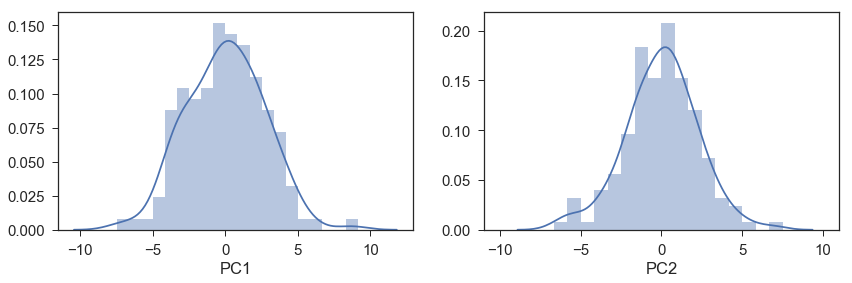

In [66]:
fig, axes = plt.subplots(1,2,figsize=(14,4)); bins = np.linspace(-10,10,25)
[sns.distplot(T3[:,i],bins=bins, ax=axes[i]) for i in range(2)]
[axes[i].set_xlabel('PC'+str(i+1)) for i in range(2)];

We can do PCA on the full, five-dimensional data in the X matrix, as well. We can use a "skree plot" to illustrate how much variance each addition component accounts for in the data (left panel below). In this case, the first component accounts for the vast majority of the data. We illustrate the distribution of the first component in the right panel.

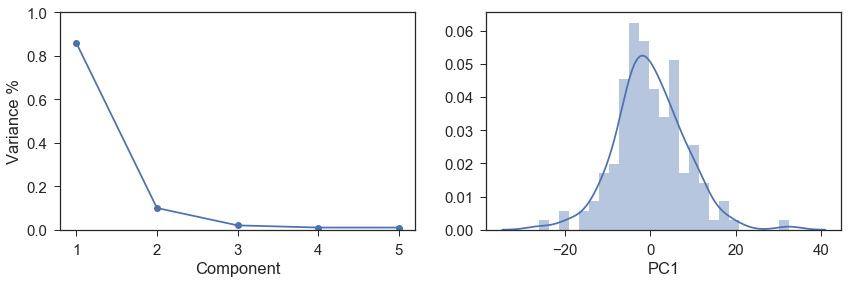

In [68]:
# create pca object
pca = PCA(n_components=5)
# fit pca model
PP = pca.fit(X)
# transform data
TT = pca.fit_transform(X)
# get components, variance
CC = PP.components_
VV = PP.explained_variance_
WW = np.round(PP.explained_variance_ratio_,2)
# make plots
fig, axes = plt.subplots(1,2,figsize=(14,4)); ax1,ax2 = axes
ax1.plot(np.arange(1,6),WW,'-o')
ax1.set(ylabel='Variance %',xlabel='Component', xticks=np.arange(1,6), ylim=(0,1));
sns.distplot(TT[:,0],ax=ax2,bins=25)
ax2.set(xlabel='PC1');

We can see how much each original variable contributes to each principal component, too. In the full `CC` variable (defined above), the rows correspond to the components, and the columns indicate the relative importance of each original variable to that component. These are sometimes called loadings.

The loadings for the first component indicate that the second variable contributes the most to PC1, followed by the fourth, fifth, first, then third:

In [69]:
print(np.round(CC[0,:],3))

[ 0.166  0.864  0.049  0.387  0.271]


### Dimensionality reduction and classification

Finally, LDA can be used as a classifier, and it will generally produce results that are very similar to those produced by logistic regression. LDA can also be thought of as a dimensionality reduction technique.

Unlike PCA, which finds combinations of variables that maximize variance, LDA finds combinations that maximize separation between groups. We'll use some of the data we generated above and make some group labels to illustrate LDA.

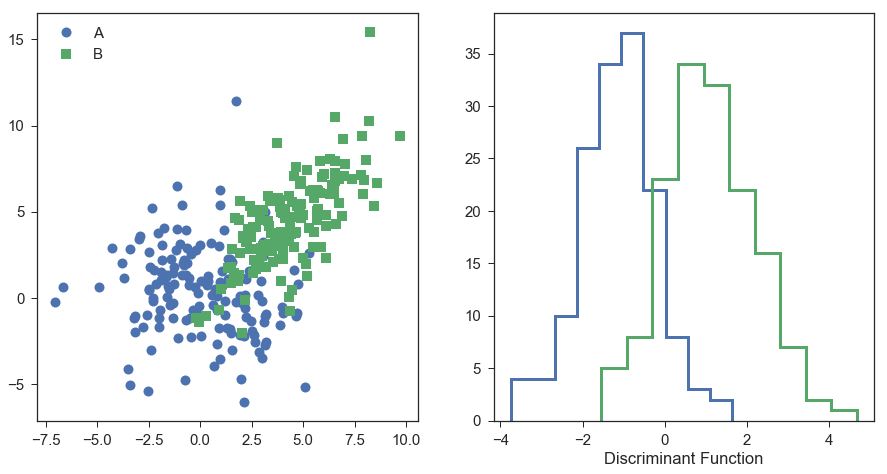

In [70]:
# make new 2D data
X4 = X2+4 # shift data in X2 by 4
XN = np.concatenate((X3,X4),axis=0) # stick them together

# make group labels for new data
npc = X3.shape[0]
a_lab = ['A' for i in range(npc)]
b_lab = ['B' for i in range(npc)]
Y = np.concatenate((a_lab,b_lab))

# create lda object
lda = LDA(n_components=2)
# fit lda model, get transformed variables
lda_f = lda.fit(XN,Y)
lda_t = lda.fit_transform(XN,Y)
#lda_t = XN @ lda_f.scalings_[:,0].T#lda.fit_transform(XN,Y)

fig, axes = plt.subplots(1,2,figsize=(15,7.5))
lA, = axes[0].plot(X3[:,0],X3[:,1],'o',ms=10)
lB, = axes[0].plot(X4[:,0],X4[:,1],'s',ms=10)
axes[0].legend([lA,lB],['A','B'])
axes[1].hist(lda_t[:npc],histtype='step',lw=3)
axes[1].hist(lda_t[npc:],histtype='step',lw=3)
axes[1].set_xlabel('Discriminant Function');

We can use this fitted model to classify a third variable in the same space:

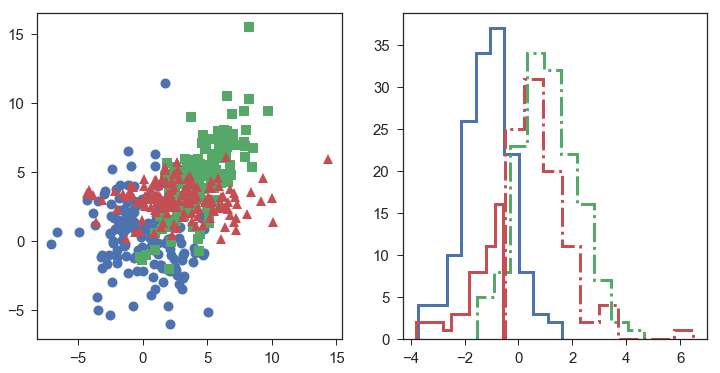

In [71]:
# make a new variable
T4 = T2+3 # shift data in T2 (transformed X2) by 3

# predict categories for the variables in T4
T4_p = lda_f.predict(T4)

# transform T4 data
#T4_t = T4 @ lda_f.scalings_ 
T4_t = lda_f.fit_transform(T4,T4_p)

fig, axes = plt.subplots(1,2,figsize=(12,6))
Ad, = axes[0].plot(X3[:,0],X3[:,1],'o',ms=10); Bd, = axes[0].plot(X4[:,0],X4[:,1],'s',ms=10);
Cd, = axes[0].plot(T4[:,0],T4[:,1],'^',ms=10);
axes[1].hist(lda_t[:npc],histtype='step',lw=3); axes[1].hist(lda_t[npc:],histtype='step',lw=3, ls='-.');
T4_Ar = np.in1d(T4_p,'A'); T4_Br = np.in1d(T4_p,'B')
axes[1].hist(T4_t[T4_Ar],color=Cd.get_c(),histtype='step',lw=3, ls='-');
axes[1].hist(T4_t[T4_Br],color=Cd.get_c(),histtype='step',lw=3, ls='-.');

Here, we've illustrated a simple case of mapping 2D data onto a single dimension. LDA can also be used with higher-dimensional data, mapping it onto lower-dimensional, but still multidimensional spaces.

Once again, we'll generate multivariate random data with correlations between the variables. Then we'll visualize the data. Finally, we'll use LDA to reduce the dimensionality.

In [72]:
np.random.seed(seed=55569)
mu = np.zeros(5)
Sa = np.linalg.inv(stats.wishart.rvs(scale=np.eye(5)/10,df=6,size=1))
Xa = np.random.multivariate_normal(mean=mu, cov=Sa, size=nsmp)
Sb = np.linalg.inv(stats.wishart.rvs(scale=np.eye(5)/10,df=6,size=1))
Xb = np.random.multivariate_normal(mean=np.random.random(size=5)*5, cov=Sb, size=nsmp)
npc = Xa.shape[0]
a_lab = ['A' for i in range(npc)]; b_lab = ['B' for i in range(npc)]; labs = np.array(a_lab + b_lab)
Xab = np.concatenate((Xa,Xb),axis=0)
df_Xab = pd.DataFrame(Xab,columns=col_names)
df_Xab['labs'] = labs

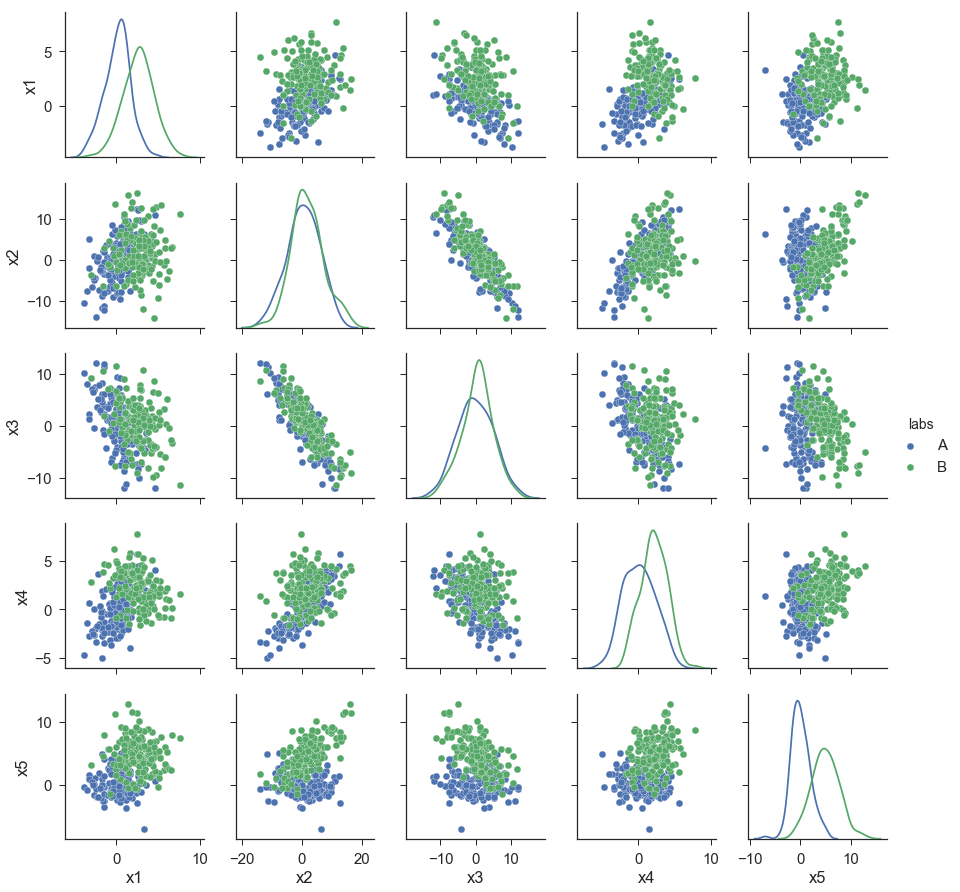

In [73]:
sns.pairplot(df_Xab,diag_kind='kde',hue='labs');

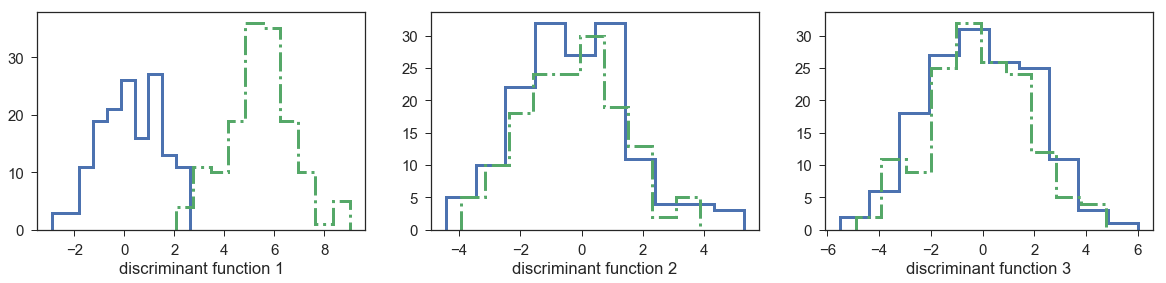

In [74]:
lda = LDA(n_components=2, solver='eigen')
lda_f = lda.fit(Xab,labs); #lda_t = lda.fit_transform(Xab,labs)
SC = lda_f.scalings_[:,:3]
lda_t = Xab @ SC
fig, axes = plt.subplots(1,3,figsize=(20,4))
axes[0].hist(lda_t[:npc,0],histtype='step',lw=3); axes[0].hist(lda_t[npc:,0],histtype='step',lw=3, ls='-.');
axes[1].hist(lda_t[:npc,1],histtype='step',lw=3); axes[1].hist(lda_t[npc:,1],histtype='step',lw=3, ls='-.');
axes[2].hist(lda_t[:npc,2],histtype='step',lw=3); axes[2].hist(lda_t[npc:,2],histtype='step',lw=3, ls='-.');
[axes[i].set_xlabel('discriminant function ' + str(i+1)) for i in range(3)];

In addition to plotting histograms of transformed data with respect to each discriminant function, we can make a scatterplot illustrating multiple discriminant functions simultaneously:

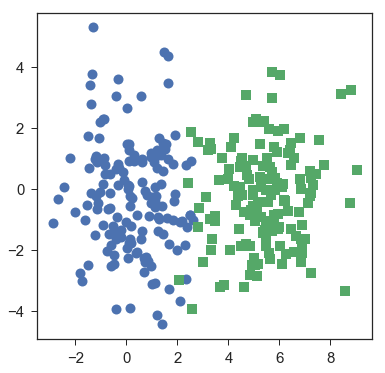

In [75]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.plot(lda_t[:npc,0],lda_t[:npc,1],'o',ms=10); ax.plot(lda_t[npc:,0],lda_t[npc:,1],'s',ms=10);

## Using these tools with real data

Simulating data can be useful for various reasons (e.g., testing to see if an algorithm will recover known parameters), but, of course, in real research, we just have a data set, and we don't know the true parameter values (if it even makes sense to think of parameters as having true value).

We'll read in some data consisting of measurements from 310 people's vertebral columns:

In [76]:
df = pd.read_csv('verterbral_column_data.csv')
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,category_2,category_3
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal,Hernia


Looking up what these measurements are (which we can do again now), I found out that pelvic incidence is pelvic tilt + sacral slope, so we'll drop pelvic incidence from our analyses.

First, we'll see how useful regularization is with lasso and ridge regression while predicting degree of spondylolisthesis as a function of pelvic tilt, lumbar lordosis angle, sacral slope, and pelvic radius.

First, we'll visualize the data:

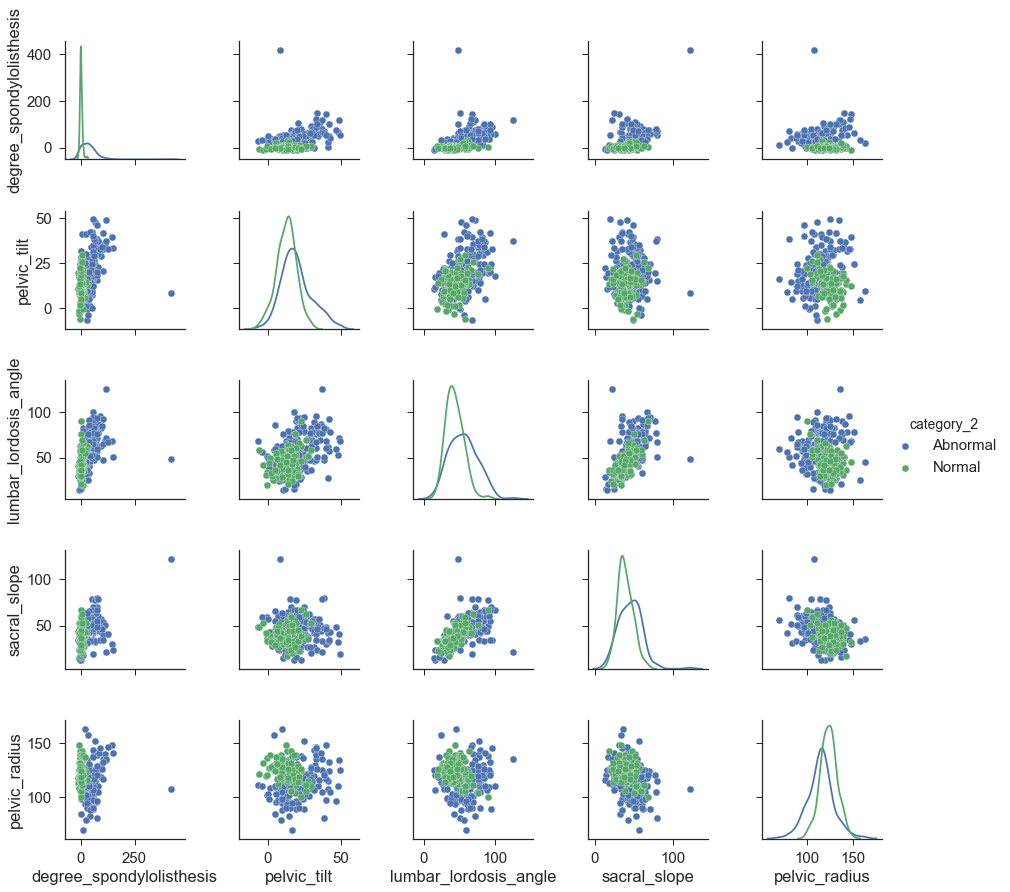

In [77]:
X_cols = list(df.columns[1:-3]) # exclude pelvic incidence
y_col = [df.columns[-3]] # degree of spondylolisthesis
sns.pairplot(df[y_col + X_cols + ['category_2']],diag_kind='kde',hue='category_2');

Normally, I am not a big fan of excluding outliers, in part because there is often ambiguity with respect to what counts as an outlier, but that one data point is very clearly unlike most of the others on multiple dimensions, so we'll drop it from our analyses.

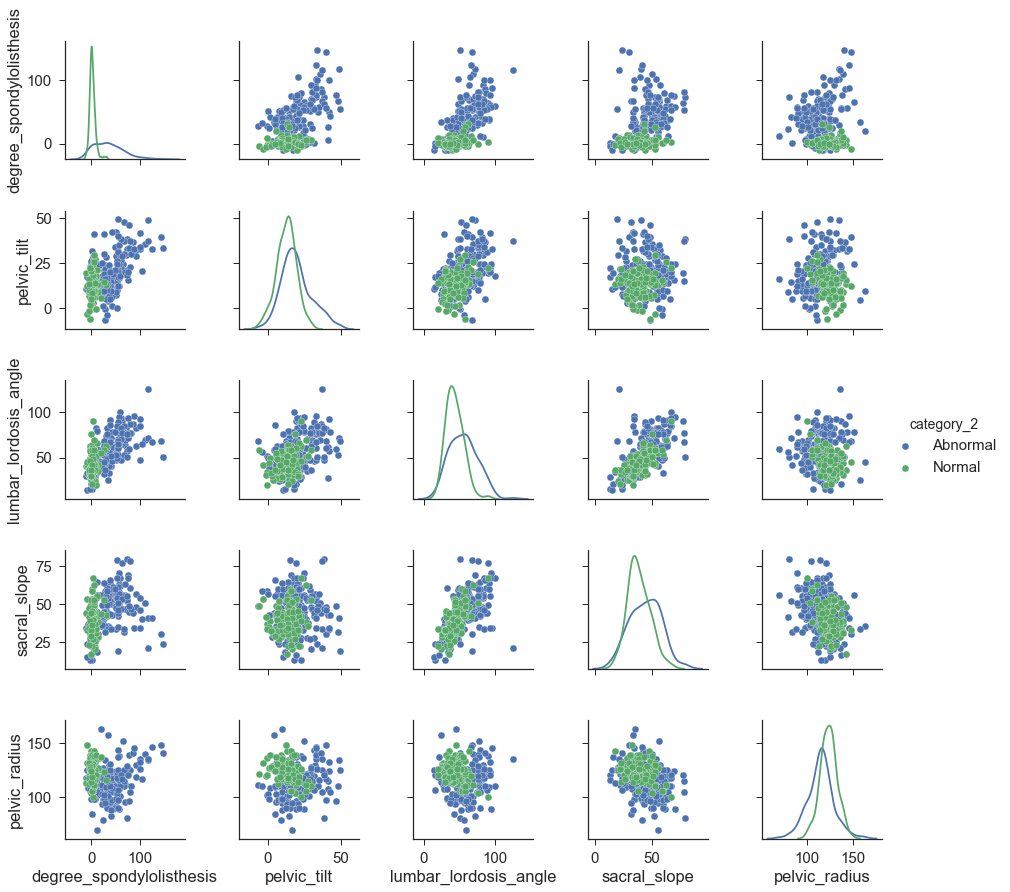

In [78]:
keep_idx = np.where(df['sacral_slope']<100)[0]
df = df.loc[keep_idx,:].copy()
sns.pairplot(df[y_col + X_cols + ['category_2']],diag_kind='kde',hue='category_2');

Next, we'll normalize the data (i.e., center and standardize each variable):

In [80]:
X = df[X_cols].as_matrix()
y = df[y_col].as_matrix()

Xz = StandardScaler().fit_transform(X) # create z scores
yz = StandardScaler().fit_transform(y) # create z score

In [89]:
# repeated parameters for testing lasso and ridge regression
n_alphas = 50
n_splits = 10
lasso_alphas = np.logspace(1, 5, n_alphas)
ridge_alphas = np.logspace(2, 6, n_alphas)
lasso_pred_err = np.zeros((2,n_splits,n_alphas))
ridge_pred_err = np.zeros((2,n_splits,n_alphas))

kf = KFold(n_splits=10, shuffle=True, random_state=17233742)

for ai, av in enumerate(zip(lasso_alphas, ridge_alphas)):
    lav, rav = av
    lasso_mod.set_params(alpha=lav)
    ridge_mod.set_params(alpha=rav)
    
    for ti, indices in enumerate(kf.split(X)):
        train_idx, test_idx = indices
        X_train = X[train_idx,:]
        y_train = y[train_idx]
        X_test = X[test_idx,:]
        y_test = y[test_idx]

        lasso_mod.fit(X_train,y_train)
        l_pred_t = lasso_mod.predict(X_test)
        lasso_pred_err[0,ti,ai] = pred_err(l_pred_t, y_test, L_norm=1)
        lasso_pred_err[1,ti,ai] = pred_err(l_pred_t, y_test, L_norm=2)
    
        ridge_mod.fit(X_train,y_train)
        r_pred_t = ridge_mod.predict(X_test)
        ridge_pred_err[0,ti,ai] = pred_err(r_pred_t, y_test, L_norm=1)
        ridge_pred_err[1,ti,ai] = pred_err(r_pred_t, y_test, L_norm=2)

lasso_error = lasso_pred_err.sum(axis=1)
ridge_error = ridge_pred_err.sum(axis=1)

le_min_idx = np.array([np.argmin(lasso_error[0,:]),np.argmin(lasso_error[1,:])])
re_min_idx = np.array([np.argmin(ridge_error[0,:]),np.argmin(ridge_error[1,:])])

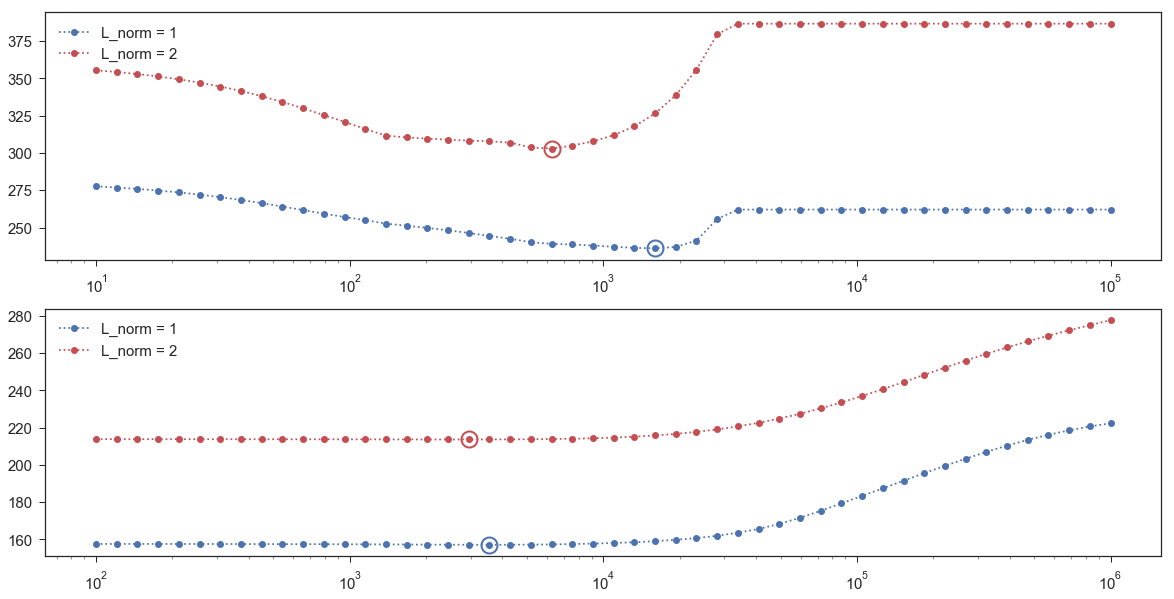

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(20,10))
axl, axr = axes
l_1, = axl.plot(lasso_alphas, lasso_error[0,:], 'o:', color=blue)
l_2, = axl.plot(lasso_alphas, lasso_error[1,:], 'o:', color=red)
axl.plot(lasso_alphas[le_min_idx[0]],lasso_error[0,le_min_idx[0]],'o',ms=16,mew=2,mfc='none',color=blue)
axl.plot(lasso_alphas[le_min_idx[1]],lasso_error[1,le_min_idx[1]],'o',ms=16,mew=2,mfc='none',color=red)
axl.legend([l_1,l_2],['L_norm = 1','L_norm = 2'])
axl.set_xscale('log'); # axl.set_yscale('log')
l_1, = axr.plot(ridge_alphas, ridge_error[0,:], 'o:', color=blue)
l_2, = axr.plot(ridge_alphas, ridge_error[1,:], 'o:', color=red)
axr.plot(ridge_alphas[re_min_idx[0]],ridge_error[0,re_min_idx[0]],'o',ms=16,mew=2,mfc='none',color=blue)
axr.plot(ridge_alphas[re_min_idx[1]],ridge_error[1,re_min_idx[1]],'o',ms=16,mew=2,mfc='none',color=red)
axr.legend([l_1,l_2],['L_norm = 1','L_norm = 2'])
axr.set_xscale('log')

The lasso fits indicate that regularization does seem to help with prediction. Note that the specific amount of regularization that produces the smallest predictione error depends on which prediction error formula you prefer, which complicates matters.

The ridge regression models do not as obviously indicate that regularization helps, though technically the minimum value of prediction error does occur with some degree of regularization.

Next, we will do LDA to see if these measures can help reduce the dimensionality of the data based on normal or abnormal status.

In [93]:
lda = LDA(n_components=3,solver='eigen')
labs = df['category_2'].as_matrix()

In [94]:
lda_f = lda.fit(X,labs); #lda_t = lda.fit_transform(Xab,labs)
SC = lda_f.scalings_[:,:3]
SC

array([[ 0.6734619 , -0.58166198,  0.80454375],
       [ 0.32103119,  0.67344608, -0.19142159],
       [-0.13544053, -0.39135957,  0.22207698],
       [-0.65195391,  0.23447259,  0.51647744]])

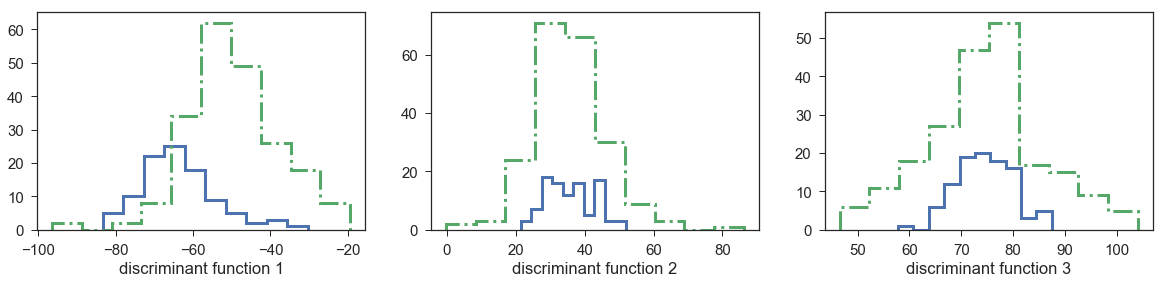

In [95]:
lda_t = X @ SC
fig, axes = plt.subplots(1,3,figsize=(20,4))
n_idx = np.in1d(labs,'Normal')
a_idx = np.in1d(labs,'Abnormal')
axes[0].hist(lda_t[n_idx,0],histtype='step',lw=3); axes[0].hist(lda_t[a_idx,0],histtype='step',lw=3, ls='-.');
axes[1].hist(lda_t[n_idx,1],histtype='step',lw=3); axes[1].hist(lda_t[a_idx,1],histtype='step',lw=3, ls='-.');
axes[2].hist(lda_t[n_idx,2],histtype='step',lw=3); axes[2].hist(lda_t[a_idx,2],histtype='step',lw=3, ls='-.');
[axes[i].set_xlabel('discriminant function ' + str(i+1)) for i in range(3)];

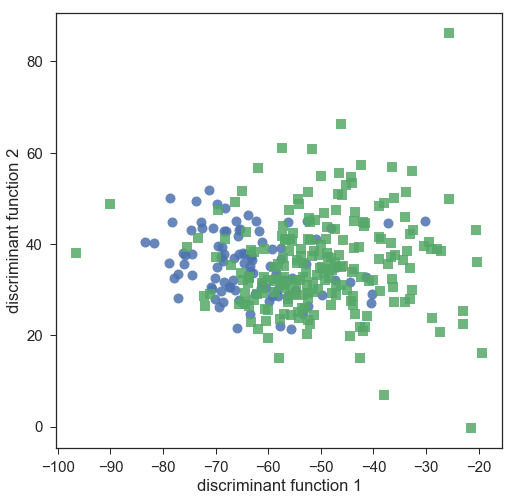

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(lda_t[n_idx,0],lda_t[n_idx,1],'o', ms=10, alpha=0.85)
ax.plot(lda_t[a_idx,0],lda_t[a_idx,1],'s', ms=10, alpha=0.85)
ax.set(xlabel='discriminant function 1', ylabel='discriminant function 2');

LDA seems to be able to provide some degree of group separation, but not very much.

Finally, since the groups don't seem to differ very much, we'll see if we can reduce the dimensionality of the whole data set using PCA:

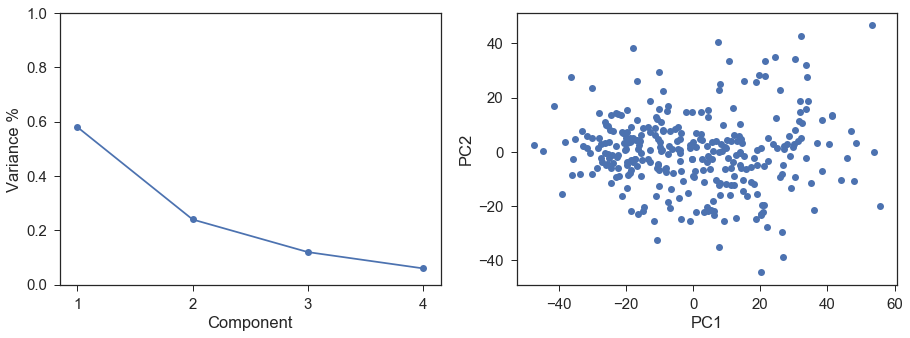

In [97]:
n_comps = X.shape[1]

# create pca object
pca = PCA(n_components=n_comps)

# fit pca model
PP = pca.fit(X)

# transform data
TT = pca.fit_transform(X)

# get components, variance
CC = PP.components_
VV = PP.explained_variance_
WW = np.round(PP.explained_variance_ratio_,2)

# make plots
fig, axes = plt.subplots(1,2,figsize=(15,5)); ax1,ax2 = axes
ax1.plot(np.arange(1,n_comps+1),WW,'-o')
ax1.set(ylabel='Variance %',xlabel='Component', xticks=np.arange(1,n_comps+1), ylim=(0,1))
ax2.set(xlabel='PC1', ylabel='PC2')
ax2.plot(TT[:,0],TT[:,1],'o');

In [98]:
CC

array([[ 0.20472   ,  0.84222362,  0.47272116, -0.15900881],
       [ 0.24303985,  0.26961993, -0.28748531,  0.88633454],
       [ 0.77774242,  0.01933437, -0.49946839, -0.38114858],
       [-0.54234499,  0.46646613, -0.66664701, -0.20941116]])

The PCA suggests that we could reduce the data from four dimensions to two without losing too much information.

Finally, we can do similar analyses with three category vertebral column data:

In [99]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,category_2,category_3
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal,Hernia


Looking up what these measurements are (which we can do again now), I found out that pelvic incidence is pelvic tilt + sacral slope, so we'll drop pelvic incidence from our analyses.

First, we'll see how useful regularization is with lasso and ridge regression while predicting degree of spondylolisthesis as a function of pelvic tilt, lumbar lordosis angle, sacral slope, and pelvic radius.

First, we'll visualize the data:

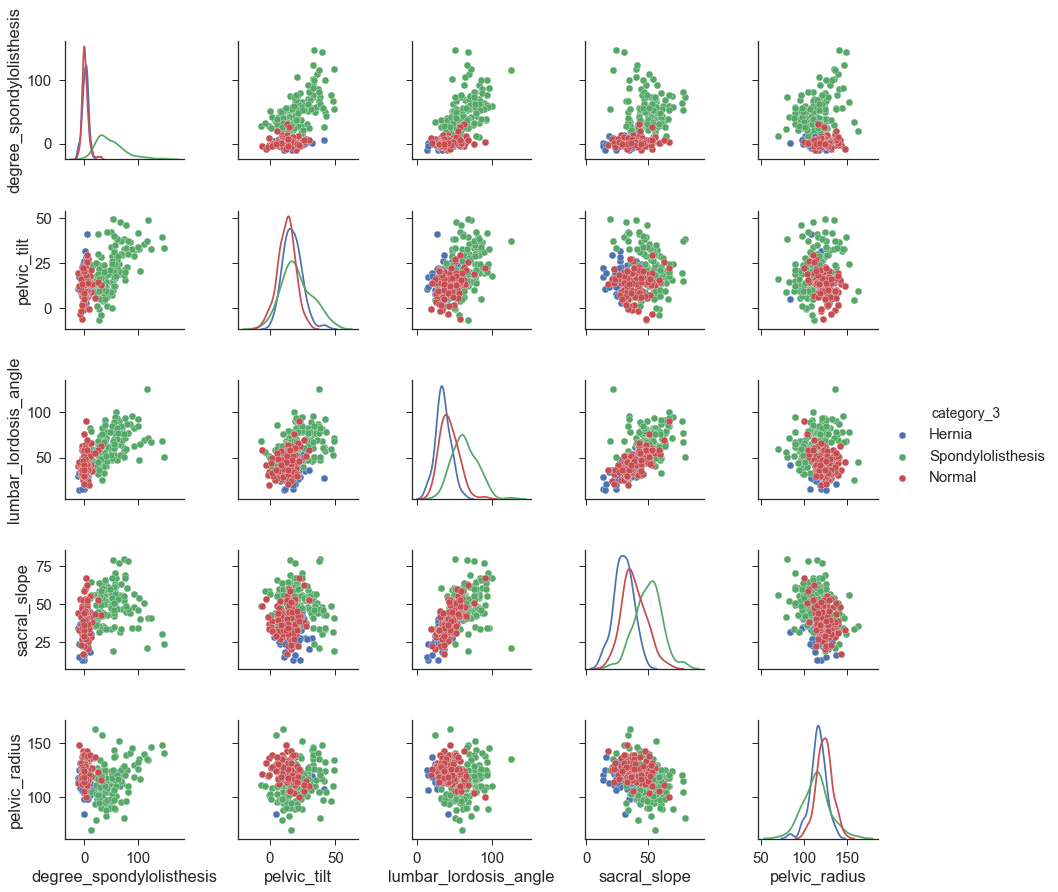

In [109]:
X_cols = list(df.columns[1:-3]) # exclude pelvic incidence
y_col = [df.columns[-3]] # degree of spondylolisthesis
sns.pairplot(df[y_col + X_cols + ['category_3']],diag_kind='kde',hue='category_3');

The measurements are the same in this data set, aside from the categorization into three categories rather than just two, so we won't do the lasso or ridge regression fits or the PCA again. Instead, we'll just do LDA with three categories:

In [110]:
lda = LDA(n_components=3,solver='eigen')
labs = df['category_3'].as_matrix()

In [111]:
lda_f = lda.fit(X,labs); #lda_t = lda.fit_transform(Xab,labs)
SC = lda_f.scalings_[:,:3]
SC

array([[-0.70674342,  0.15207649, -0.44104563],
       [ 0.37727733,  0.41185173,  0.61472694],
       [-0.16562919, -0.16523565,  0.47457787],
       [-0.44881769, -0.63275007,  0.20914577],
       [ 0.35959034, -0.61609692, -0.39827557]])

In [112]:
np.unique(df['category_3'])

array(['Hernia', 'Normal', 'Spondylolisthesis'], dtype=object)

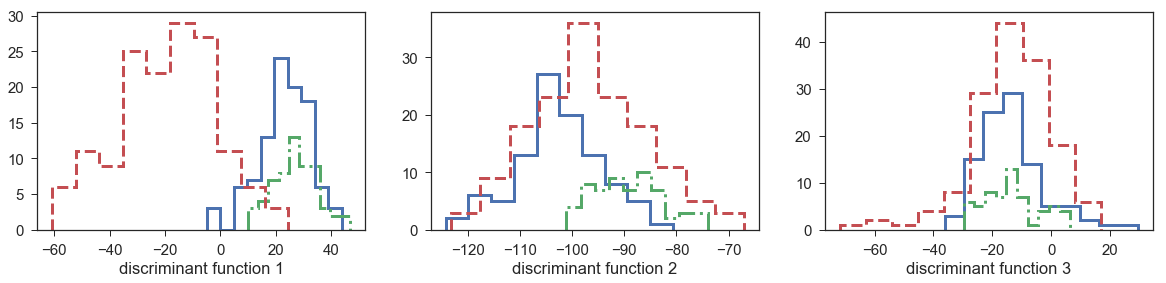

In [113]:
lda_t = X @ SC
fig, axes = plt.subplots(1,3,figsize=(20,4))
n_idx = np.in1d(labs,'Normal')
h_idx = np.in1d(labs,'Hernia')
s_idx = np.in1d(labs,'Spondylolisthesis')
axes[0].hist(lda_t[n_idx,0],histtype='step',lw=3) # blue = normal
axes[0].hist(lda_t[h_idx,0],histtype='step',lw=3, ls='-.') # green = hernia
axes[0].hist(lda_t[s_idx,0],histtype='step',lw=3, ls='--') # red = spondylolisthesis

axes[1].hist(lda_t[n_idx,1],histtype='step',lw=3) # blue = normal
axes[1].hist(lda_t[h_idx,1],histtype='step',lw=3, ls='-.') # green = hernia
axes[1].hist(lda_t[s_idx,1],histtype='step',lw=3, ls='--') # red = spondylolisthesis

axes[2].hist(lda_t[n_idx,2],histtype='step',lw=3) # blue = normal
axes[2].hist(lda_t[h_idx,2],histtype='step',lw=3, ls='-.') # green = hernia
axes[2].hist(lda_t[s_idx,2],histtype='step',lw=3, ls='--') # red = spondylolisthesis

[axes[i].set_xlabel('discriminant function ' + str(i+1)) for i in range(3)];

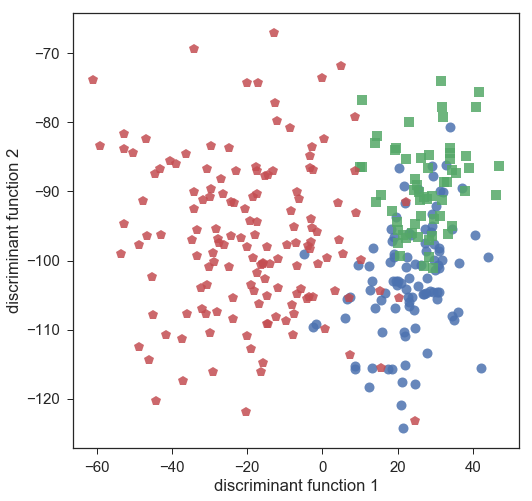

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(lda_t[n_idx,0],lda_t[n_idx,1],'o', ms=10, alpha=0.85)
ax.plot(lda_t[h_idx,0],lda_t[h_idx,1],'s', ms=10, alpha=0.85)
ax.plot(lda_t[s_idx,0],lda_t[s_idx,1],'p', ms=10, alpha=0.85)
ax.set(xlabel='discriminant function 1', ylabel='discriminant function 2');